In [1]:
import numpy as np
import cv2 as cv
from PIL import Image
from src import *
import matplotlib.pyplot as plt
import pandas as pd
import skimage


# Calibration

In [2]:
img = Image.open('./data/image0044.png')
points = select_points(img)

# points = np.array([[498, 673],
#        [398, 294],
#        [463, 357],
#        [594, 361],
#        [664, 429],
#        [735, 534],
#        [812, 611],
#        [756, 281],
#        [932, 587]])

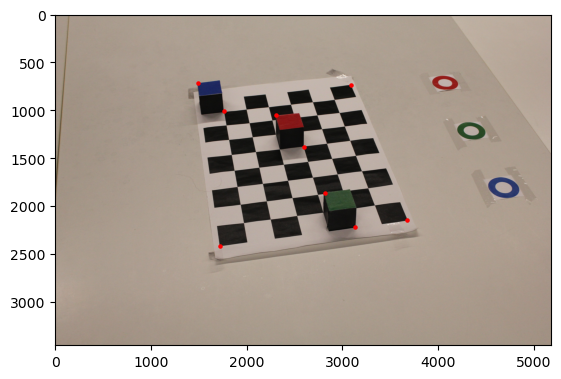

In [3]:
pts = points.copy()
plt.imshow(img)
plt.scatter(*pts.T, s=5, c='r')

In [4]:
points3 = pd.read_csv('./data/3d_points.csv', index_col=0)
points3 = points3.iloc[:, -3:].to_numpy()

M = calibrate_norm(points, points3)

In [5]:
intrinsic, extrinsic = extract_params(M)

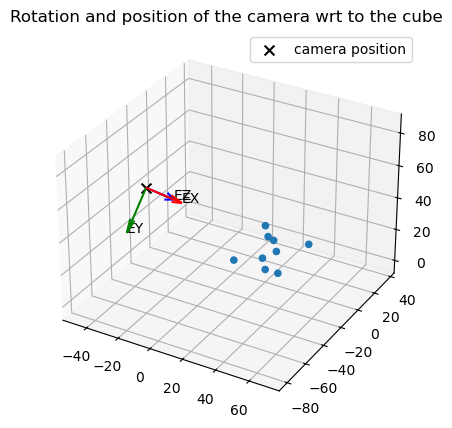

In [6]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(projection='3d')
ax.set_title("Rotation and position of the camera wrt to the cube")
ax.grid(True)
ax.scatter(*points3.T, alpha=1)
plot_frame(extrinsic, ax, name="E", l=25, s=50)

plt.legend()
plt.axis('equal')
plt.show()



# Robot detection

## Idea:

- threshold colors using HSV images
- find areas and their coordinates
- transform into world coordinates:
$
    \begin{bmatrix} X \\ Y \\ W \end{bmatrix} = 
    M_{\{1,2,4\}}^{-1} \left(
    \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} - M_{\{3\}} Z
    \right),
$
- $M$ and $Z$ is known
- $X = \frac{X}{W}$, $Y=\frac{Y}{W}$
- find center of mass from $X$ and $Y$ $\rightarrow$ object location

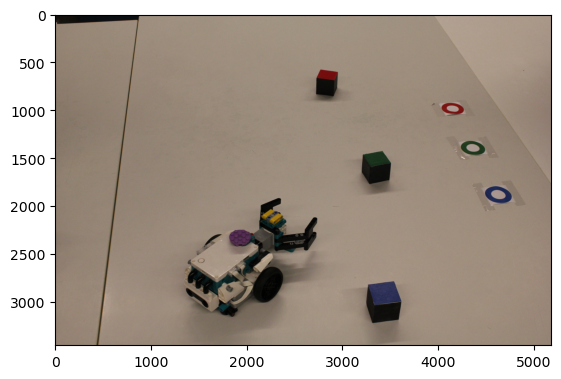

In [9]:
test = Image.open('./data/set2/images/image0002.png')
test = np.array(test)
# test = Image.open('./data/showcase/bot.png')
plt.imshow(test)

0


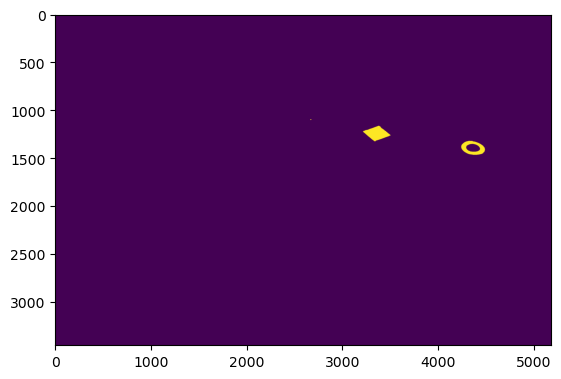

In [18]:
hsv = cv.cvtColor(np.array(test), cv.COLOR_RGB2HSV)

green = cv.inRange(hsv, (40, 30, 30), (70, 255, 245))

opened = cv.morphologyEx(green, cv.MORPH_OPEN, np.ones((5, 5)))
closed = cv.morphologyEx(opened, cv.MORPH_CLOSE, np.ones((11, 11)))

labels = skimage.measure.label(closed)
regions = skimage.measure.regionprops(labels)

areas = [r.area for r in regions]
idx = np.argsort(areas)[::-1]

regions = [regions[i] for i in idx[:2]]

y, x = map(int, regions[1].centroid)
print(closed[y, x])

plt.imshow(closed)


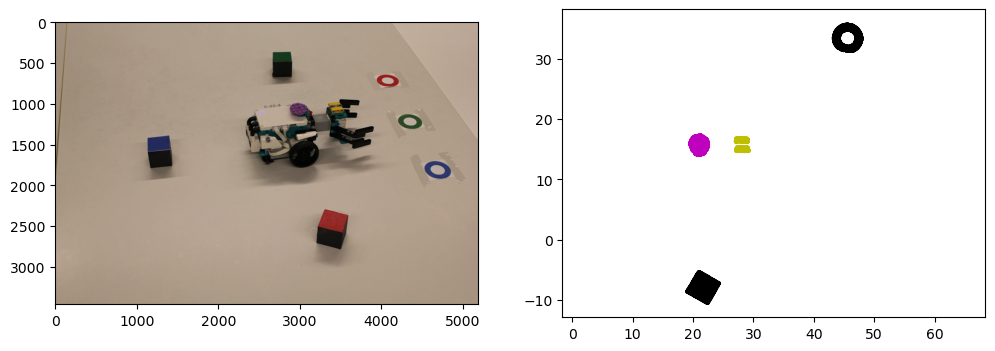

In [7]:
test = Image.open('./data/image0051.png')

centroids = locate_bot(test)

disk, bar1, bar2 = centroids

out = locate_red(test)

A = np.linalg.inv(M[:, [0, 1, 3]])
b = M[:, 2:3]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(test)

for points, z, c in zip((disk, bar1, bar2, *out),
                     (9, 8.5, 8.5, 4, 0),
                     ('m', 'y', 'y', 'k', 'k')):
    n = len(points)
    points = np.concat((points.T, [[1] * n]), 0)
    out = A @ (points - z * b)
    x, y = out[:-1] / out[-1]
    ax2.scatter(x, y, c=c, marker='.', s=0.1)

plt.axis('equal')
plt.show()


In [8]:
def to_world(points, A, b, z):
    n = len(points)
    points = np.concat((points.T, [[1] * n]), 0)
    out = A @ (points - z * b)
    return (out[:-1] / out[-1]).T


def foo(img: Image, color: str, M: np.array):

    disk, bar1, bar2 = locate_bot(img)
    bar = np.concatenate((bar1, bar2))

    # if color == 'red':
    #     block, goal = locate_red(img)
    # if color == 'blue':
    #     block, goal = locate_blue(img)
    # if color == 'green':
    #     block, goal = locate_green(img)

    A = np.linalg.inv(M[:, [0, 1, 3]])
    b = M[:, 2:3]

    disk = to_world(disk, A, b, 8.9).mean(0)
    bar = to_world(bar, A, b, 8.4).mean(0)

    for fun in (locate_red, locate_green, locate_blue):

        block, goal = fun(img)
        block = to_world(block, A, b, 4).mean(0)
        goal = to_world(goal, A, b, 0).mean(0)

    # plt.scatter(*disk.T)
    # plt.scatter(*bar.T)
    # plt.scatter(*block.T)
    # plt.scatter(*goal.T)

    # plt.quiver(*disk, *(bar - disk))
    # plt.quiver(*disk, *(block - disk))

        r_disk_bar = bar - disk
        r_disk_block = block - disk
        r_block_goal = goal - block
        distance_bar = np.linalg.norm(r_disk_bar)
        distance_block = np.linalg.norm(r_disk_block)
        distance_goal = np.linalg.norm(r_block_goal)

        sign_block = -np.sign(r_disk_bar[0] * r_disk_block[1] - r_disk_bar[1] * r_disk_block[0])
        rotate_block = sign_block * np.acos((r_disk_bar @ r_disk_block) / (distance_bar * distance_block)) * 180 / np.pi

        sign_goal = -np.sign(r_disk_block[0] * r_block_goal[1] - r_disk_block[1] * r_block_goal[0])
        rotate_goal = sign_goal * np.acos((r_disk_block @ r_block_goal) / (distance_block * distance_goal)) * 180 / np.pi

        print(f'turn({rotate_block:.0f});go({distance_block:.0f});grab();turn({rotate_goal:.0f});go({distance_goal - 12:.0f});let_go();go(-20);', end='')

        disk = goal - 32 * r_block_goal / distance_goal
        bar = goal

    # plt.scatter(*end.T, marker='x')
    # plt.axis('equal')


test = Image.open('./data/image0051.png')
foo(test, 'red', M)


turn(89);go(24);grab();turn(-148);go(36);let_go();go(-20);turn(-41);go(35);grab();turn(144);go(19);let_go();go(-20);turn(94);go(37);grab();turn(-124);go(39);let_go();go(-20);